In [1]:
# !rm -rf data/ecgs.zarr
# !./ingest_ecg_records.py

In [2]:
SCORED_CODES = [
    270492004,
    164889003,
    164890007,
    426627000,
    713427006,
    713426002,
    445118002,
    39732003,
    164909002,
    251146004,
    698252002,
    10370003,
    284470004,
    427172004,
    164947007,
    111975006,
    164917005,
    47665007,
    59118001,
    427393009,
    426177001,
    426783006,
    427084000,
    63593006,
    164934002,
    59931005,
    17338001,
]

In [3]:
from scipy import stats

In [4]:
import zarr
import numpy as np
import matplotlib.pyplot as plt
import json
import scipy.signal as ss
from sklearn.preprocessing import normalize, MultiLabelBinarizer
from sklearn.neighbors import KernelDensity, LocalOutlierFactor

from utils import walk_files
# store = zarr.DirectoryStore("data/ecgs.zarr")
# root = zarr.group(store=store, overwrite=False)
# root = zarr.open("data/ecgs.zarr")

root = zarr.open_group("data/ecgs.zarr", mode="r")
root.info

Name,/
Type,zarr.hierarchy.Group
Read-only,True
Store type,zarr.storage.DirectoryStore
No. members,4
No. arrays,0
No. groups,4
Groups,"beats, cleaned, meta, raw"


In [5]:
record_files = tuple(walk_files("data", suffix=".hea", prefix=True, remove_suffix=True))

In [54]:
print(root.tree())

/
 ├── beats
 │   ├── r_peak_idxs (43099,) object
 │   ├── valid_r_peak_idxs (43099,) object
 │   ├── window_size_400 (43099,) object
 │   ├── window_size_400_normalized (43099,) object
 │   ├── window_size_400_normalized_flattened (801266, 400, 12) float32
 │   ├── window_size_400_outlier (43099,) int32
 │   └── window_size_400_shape (43099, 3) int32
 ├── cleaned
 │   └── p_signal (43099,) object
 ├── meta
 │   └── record_idx_to_window_400_range (1,) object
 ├── raw
 │   ├── dx (43099,) object
 │   ├── meta (43099, 3) int32
 │   ├── p_signal (43099,) object
 │   └── p_signal_shape (43099, 2) int32
 └── seq_embeddings
     ├── version_0 (43099, 768) float64
     ├── version_1 (43099, 768) float64
     ├── version_10 (43099, 768) float64
     ├── version_11 (43099, 768) float64
     ├── version_12 (43099, 768) float64
     ├── version_13 (43099, 768) float64
     ├── version_14 (43099, 768) float64
     ├── version_15 (43099, 768) float64
     ├── version_16 (43099, 768) float64
     ├─

In [7]:
# root["meta/record_idx_to_window_400_range"][0]["11721"]
# root["beats/window_size_400_normalized_flattened"][0]
# root["cinc_mfe/all_cinc_2020_features"].info

In [8]:
mlb = MultiLabelBinarizer(classes=SCORED_CODES)
# # mlb.fit([])
# print(dx)
# mlb.fit_transform([dx, ])

In [9]:
def get_signal(idx):
    signal = root["raw/p_signal"][idx].reshape(root["raw/p_signal_shape"][idx], order="C")
    cleaned_signal = root["cleaned/p_signal"][idx].reshape(root["raw/p_signal_shape"][idx], order="C")
    age, sex, fs = root["raw/meta"][idx]
    dx = root["raw/dx"][idx]
    
    beats = root["beats/r_peak_idxs"][idx]
    valid_beats = root["beats/valid_r_peak_idxs"][idx]

#     beat_windows = root["beats/window_size_400"][idx].reshape(root["beats/window_size_400_shape"][idx], order="C")
    beat_windows = root["beats/window_size_400_normalized"][idx].reshape(root["beats/window_size_400_shape"][idx], order="C")
    outlier = root["beats/window_size_400_outlier"][idx]
    bin_dx = mlb.fit_transform([dx,])

    return signal, cleaned_signal, age, sex, fs, dx, bin_dx, beats, valid_beats, beat_windows, outlier


/home/alexwong/miniconda3/envs/msc_research/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:994: UserWarning: unknown class(es) [164867002] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'


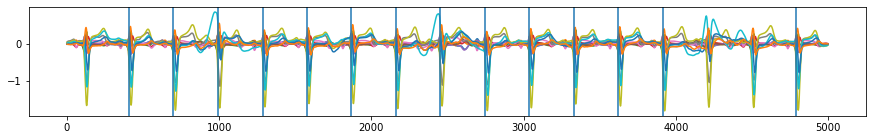

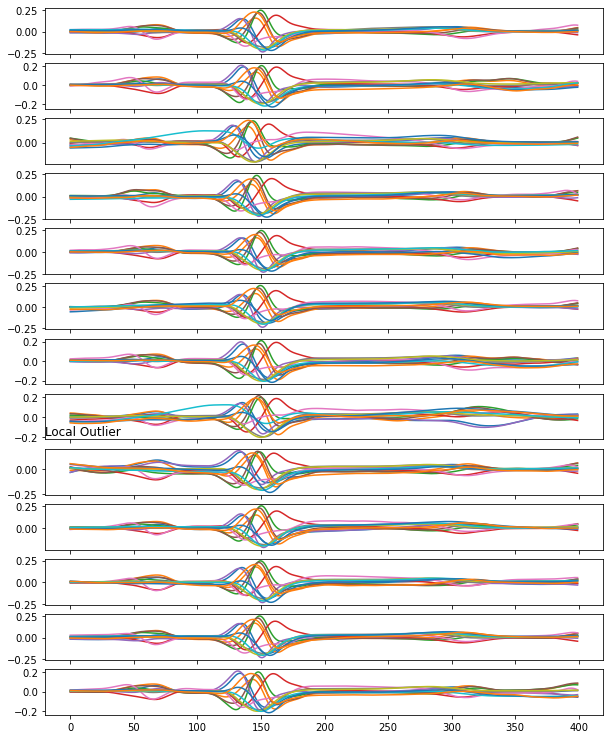

(5000, 12) 53 0 500 [164867002 427084000] (13, 400, 12) 7


(1, 27)

In [10]:
(
    signal,
    cleaned_signal,
    age,
    sex,
    fs,
    dx,
    bin_dx,
    beats,
    valid_beats,
    beat_windows,
    outlier
) = get_signal(0)#(43098)
# 384 uglllee


# plt.plot(signal)
# plt.show()
fig, axs = plt.subplots(1, figsize=(15, 2))
axs.plot(cleaned_signal)
# print(cleaned_signal.shape)
all_r_peaks_flat = np.concatenate(beats)[:, np.newaxis]
sig_range = np.linspace(0, all_r_peaks_flat.max(), len(cleaned_signal))[:, np.newaxis]
for sc in sig_range[valid_beats]:
    plt.axvline(x=sc)
plt.show()

# find outlier
# clf = LocalOutlierFactor(n_neighbors=len(beat_windows)//2)
# print(clf.fit_predict(beat_windows.reshape(len(beat_windows), -1)))
# print(clf.negative_outlier_factor_)
# outlier_idx = clf.negative_outlier_factor_.argmin()

fig, axs = plt.subplots(len(beat_windows), sharex=True, figsize=(10, len(beat_windows)))
for i in range(len(beat_windows)):
    if i == outlier:
        axs[i].set_title("Local Outlier", pad=0, y=0.1, loc="left")
    try:
        axs[i].plot(beat_windows[i])
    except TypeError:
        axs.plot(beat_windows[i])
    # axs[i].plot(normalize(valid_windows[i].T).T)
plt.show()

print(signal.shape, age, sex, fs, dx, beat_windows.shape, outlier)
# beat_windows[0]
bin_dx.shape

In [11]:
mlb = MultiLabelBinarizer()

### Normalized Windows Summary Stats

In [12]:
counter = {}
for idx, shape in enumerate(root[f"beats/window_size_{400}_shape"]):
    beat_len = shape[0]
    counter[beat_len] = counter.get(beat_len, []) + [idx,]

In [13]:
len_counts = [(kv[0], len(kv[1])) for kv in counter.items()]
# print(len_counts)
sorted(
    len_counts,
    key=lambda tup: tup[1]
)
print(len_counts)
# counter[5]

[(13, 3583), (16, 1436), (17, 1006), (12, 4662), (58, 20), (30, 104), (15, 1965), (8, 3304), (85, 3), (49, 24), (64, 9), (11, 5695), (39, 53), (72, 9), (20, 511), (25, 161), (28, 123), (19, 563), (14, 2737), (63, 12), (27, 139), (10, 6091), (54, 29), (55, 16), (40, 44), (43, 33), (23, 266), (9, 5177), (21, 407), (44, 44), (37, 66), (18, 882), (38, 69), (66, 6), (22, 324), (36, 37), (68, 8), (61, 11), (75, 6), (33, 66), (42, 50), (51, 35), (53, 27), (35, 65), (32, 80), (92, 3), (31, 85), (127, 11), (24, 218), (7, 1239), (29, 110), (59, 20), (6, 274), (57, 18), (34, 61), (45, 38), (77, 5), (60, 11), (52, 16), (48, 29), (41, 48), (144, 7), (2, 3), (62, 10), (26, 145), (74, 6), (56, 18), (71, 5), (97, 2), (94, 7), (78, 7), (84, 5), (93, 4), (4, 4), (47, 30), (73, 5), (50, 20), (76, 9), (81, 5), (90, 2), (46, 25), (105, 7), (5, 41), (86, 4), (88, 5), (91, 4), (154, 8), (65, 7), (80, 5), (89, 1), (83, 5), (113, 6), (69, 4), (142, 7), (67, 4), (146, 4), (179, 2), (106, 4), (162, 9), (70, 1), 

In [14]:
# slow.
# from scipy.stats import describe
# desc = describe(root[f"beats/window_size_{400}_normalized_flattened"])
# d_min, d_max = desc.minmax
# print(min(d_min.flatten()), max(d_max.flatten()))

## Debugging

In [15]:
all_sparse_labels = mlb.fit_transform(root["raw/dx"][:])
# all_sparse_labels.shape
num_total, classes = all_sparse_labels.shape
positive = all_sparse_labels.sum(axis=0)
negative = num_total - positive
negative

label_weights = negative / positive
label_weights = label_weights / (max(label_weights) / 2)
label_weights  # label_weights.tolist()

array([3.33294662e-01, 1.45524730e-02, 6.64271255e-03, 2.03622309e-02,
       2.85674509e-01, 5.43317333e-03, 3.91701903e-02, 3.33294662e-01,
       2.82224829e-04, 4.63754356e-03, 9.99976797e-01, 3.99962875e-01,
       5.40089024e-02, 6.66635729e-01, 4.76139799e-03, 2.52765643e-03,
       3.33294662e-01, 7.86252921e-04, 1.75219702e-03, 9.99976797e-01,
       9.25613556e-03, 2.22180973e-01, 7.40293869e-02, 2.26813942e-02,
       9.99976797e-01, 4.99965196e-01, 2.00000000e+00, 9.99976797e-01,
       2.00000000e+00, 2.85674509e-01, 8.57448381e-03, 2.00000000e+00,
       1.27550187e-03, 7.35167564e-04, 2.85882954e-04, 1.66596263e-03,
       4.85662878e-04, 9.82424590e-04, 5.29147057e-04, 6.32316868e-03,
       1.66624128e-01, 5.25863943e-02, 1.87486830e-03, 1.92797361e-03,
       1.81775995e-01, 1.30955780e-03, 4.37847556e-03, 3.81594649e-04,
       2.00000000e+00, 5.83608356e-03, 5.43752413e-04, 3.44371529e-02,
       2.49959395e-01, 4.87352138e-02, 2.85674509e-01, 3.22124071e-02,
      

In [16]:
all_sparse_labels[:, 0].shape

(43099,)

In [17]:
# def _find_normalized_outlier(idx):
#     windows = root[f"beats/window_size_{window_size}"][idx].reshape(
#         root[f"beats/window_size_{window_size}_shape"][idx], order="C"
#     )
#     windows = np.nan_to_num(windows)
#     return np.transpose(np.stack(list(map(normalize, np.transpose(windows, axes=(0, 2, 1))))), axes=(0, 2, 1))
# beat_windows = _find_normalized_outlier(0)

# print(beat_windows.shape)

# fig, axs = plt.subplots(len(beat_windows), sharex=True, figsize=(10, len(beat_windows)))
# for i in range(len(beat_windows)):
#     if i == outlier_idx:
#         axs[i].set_title("Local Outlier", pad=0, y=0.1, loc="left")
#     axs[i].plot(beat_windows[i])
#     # axs[i].plot(normalize(valid_windows[i].T).T)
# plt.show()

In [18]:
import tqdm
# for i in tqdm.trange(43099):
#     assert all(np.isfinite(root["cleaned/p_signal"][i])), i

In [19]:
with open("data/snomed_ct_dx_map.json") as f:
    snomed_map = json.load(f)

for sc in SCORED_CODES:
    print(sc, ", #", snomed_map[str(sc)])


270492004 , # ['IAVB', '1st degree av block']
164889003 , # ['AF', 'atrial fibrillation']
164890007 , # ['AFL', 'atrial flutter']
426627000 , # ['Brady', 'bradycardia']
713427006 , # ['CRBBB', 'complete right bundle branch block']
713426002 , # ['IRBBB', 'incomplete right bundle branch block']
445118002 , # ['LAnFB', 'left anterior fascicular block']
39732003 , # ['LAD', 'left axis deviation']
164909002 , # ['LBBB', 'left bundle branch block']
251146004 , # ['LQRSV', 'low qrs voltages']
698252002 , # ['NSIVCB', 'nonspecific intraventricular conduction disorder']
10370003 , # ['PR', 'pacing rhythm']
284470004 , # ['PAC', 'premature atrial contraction']
427172004 , # ['PVC', 'premature ventricular contractions']
164947007 , # ['LPR', 'Prolonged PR interval']
111975006 , # ['LQT', 'prolonged qt interval']
164917005 , # ['QAb', 'qwave abnormal']
47665007 , # ['RAD', 'right axis deviation']
59118001 , # ['RBBB', 'right bundle branch block']
427393009 , # ['SA', 'sinus arrhythmia']
426177001

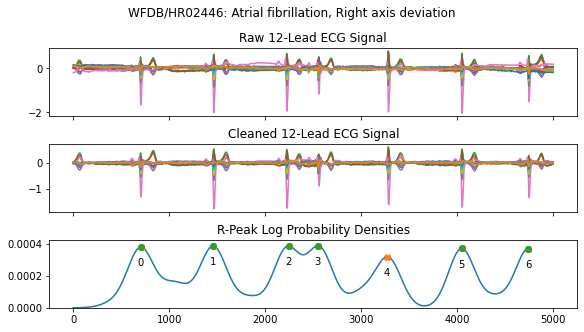

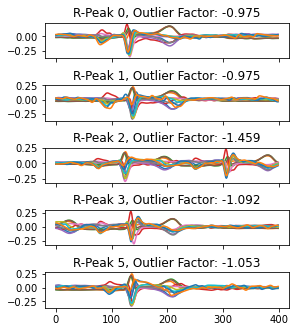

In [20]:
import neurokit2 as nk
window_size = 400
def _generate_beats(idx):
    p_signal = root["cleaned/p_signal"][idx].reshape(
        root["raw/p_signal_shape"][idx], order="C"
    )
    a, b, fs = root["raw/meta"][idx]
    dxs = root["raw/dx"][idx]
    str_abbrvs = [
        snomed_map[str(dx)][1].capitalize() for dx in dxs if dx in SCORED_CODES
    ]
    # print(a, b,str_abbrvs)

    raw_p_signal = root["raw/p_signal"][idx].reshape(
        root["raw/p_signal_shape"][idx], order="C"
    )
    
    def nk_ecg_peaks(cleaned_signal, sampling_rate=fs):
        try:
            _, ecg_r_peaks_dict = nk.ecg_peaks(
                cleaned_signal,
                sampling_rate=sampling_rate,
                method="neurokit",
                correct_artifacts=True,
            )
            r_peaks = ecg_r_peaks_dict["ECG_R_Peaks"].tolist()
            return r_peaks
        except Exception:
            return []

    all_r_peaks = list(map(nk_ecg_peaks, p_signal.T))

#     print(all_r_peaks)
    # Join all of the R-peaks into a single vector
    all_r_peaks_flat = np.concatenate(all_r_peaks)[:, np.newaxis]
    sig_range = np.linspace(0, all_r_peaks_flat.max(), len(p_signal))[:, np.newaxis]

    # Find the peaks with bandwidth proportional to rough mean RR
    mean_beats_detected = np.mean([len(r_peaks) for r_peaks in all_r_peaks])
    rough_meanrr = np.mean(
        [np.diff(r_peaks).mean() for r_peaks in all_r_peaks if len(r_peaks) >= 2 and len(r_peaks) >= mean_beats_detected]
    )
    kde = KernelDensity(bandwidth=rough_meanrr / 4).fit(all_r_peaks_flat)
#     kde = KernelDensity(bandwidth=5000).fit(all_r_peaks_flat)

    log_dens = kde.score_samples(sig_range)
    dens = np.exp(log_dens)
    peaks, _ = ss.find_peaks(dens)

    # keep only the peaks that are greater than thereshold density
    threshold_peak_density = dens[peaks].mean() - (2 * dens[peaks].std())
    valid_peaks = peaks[dens[peaks] > threshold_peak_density]

    # DISPLAY/DEBUG
    fig, axs = plt.subplots(3, sharex=True, figsize=(8, 4.5), constrained_layout=True)
    record_name = record_files[idx][5:]
    labels = ", ".join(str_abbrvs)
    fig.suptitle(f"{record_name}: {labels}")
    axs[0].set_title("Raw 12-Lead ECG Signal")
    axs[0].plot(raw_p_signal)
    axs[1].set_title("Cleaned 12-Lead ECG Signal")
    axs[1].plot(p_signal)
    axs[2].set_title("R-Peak Log Probability Densities")
    axs[2].plot(sig_range[:, 0], dens)
    axs[2].plot(sig_range[peaks], dens[peaks], "X")
    axs[2].plot(sig_range[valid_peaks], dens[valid_peaks], "o")
    for idx, (x, y) in enumerate(zip(sig_range[peaks], dens[peaks])):
        axs[2].text(
            x, y-0.0001, idx,
            horizontalalignment='center',
            verticalalignment='center')
    axs[2].set_ylim([0, max(dens) * 1.1])
    # fig.suptitle(f"Prior Resample {p_signal.shape}")
#     for vpeak in sig_range[valid_peaks]:
#         plt.axvline(x=vpeak)
    plt.savefig("fig/raw_clean_peaks.pdf", dpi=300)
    plt.show()
    
#     r_peak_idxs[idx] = all_r_peaks
#     valid_r_peak_idxs[idx] = valid_peaks

    # resample the signal such that the mean distance between
    # valid R-peaks is equal to `window_size`
    scaling_indicies = sig_range[valid_peaks].squeeze()
    scaling_indicies = np.insert(scaling_indicies, 0, 0)
    scaling_indicies = np.append(scaling_indicies, len(p_signal))
    peak_diff_dist = np.diff(scaling_indicies)
    mean_peak_diff_dist = peak_diff_dist.mean()
    resamp_to_len = (len(p_signal) / mean_peak_diff_dist) * window_size
    resamp_to_len = int(np.ceil(resamp_to_len))
    p_signal = ss.resample(p_signal, resamp_to_len)

    # resample the peaks so we don't have to calculate again
    scaling_factor = window_size / mean_peak_diff_dist
    upscaled_peak_diff_dist = peak_diff_dist * scaling_factor
    scaled_indicies = np.r_[scaling_indicies[0], upscaled_peak_diff_dist].cumsum()
    scaled_indicies = scaled_indicies[1:-1]

    valid_window_idxs = [
        idx for (idx, val) in enumerate(dens[peaks] > threshold_peak_density) if val
    ]
    
    # slice up the windows and return the new matrices
    valid_windows = []
    sc_loffset = window_size * 0.33
    for idx, sc in enumerate(scaled_indicies):
        left_offset = int(np.floor(sc - sc_loffset))
        scaled_window = p_signal[left_offset : left_offset + window_size]
        if len(scaled_window) != window_size:
            # ignore windows that don't fit into window size
            continue
        valid_windows.append(scaled_window)

    valid_windows = np.stack(valid_windows)
#     beat_windows[idx] = valid_windows.flatten(order="C")
#     beat_window_shapes[idx] = valid_windows.shape

    norm_windows = np.transpose(
        np.stack(
            list(map(normalize, np.transpose(valid_windows, axes=(0, 2, 1))))
        ),
        axes=(0, 2, 1),
    )

    outlier_idx = 0  # only one beat extracted case
    if len(norm_windows) > 1:
        clf = LocalOutlierFactor(
            n_neighbors=max(
                1, min(len(norm_windows) - 1, len(norm_windows) // 2)
            )
        )
        clf.fit_predict(norm_windows.reshape(len(norm_windows), -1))
        outlier_idx = clf.negative_outlier_factor_.argmin()
    
    fig, axs = plt.subplots(len(norm_windows), sharex=True, figsize=(4,4.5), constrained_layout=True)
    for idx, norm_window in enumerate(norm_windows):
        title = f"R-Peak {valid_window_idxs[idx]}, Outlier Factor: {clf.negative_outlier_factor_[idx]:.3f}"
#         if idx == outlier_idx:
#             title += "; Outlier"
        axs[idx].set_title(title)
        axs[idx].plot(norm_window)
    plt.savefig("fig/r_peak_windows.pdf", dpi=300)
    plt.show()

    
    return valid_windows

# _generate_beats(10521)  # meh example of cleaned signal
# _generate_beats(22988)  # meh methodology figure?
_generate_beats(23117)  # really nice one showing abnormality
# _generate_beats(35607)

None

(4769, 12)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
[(9, -1.008166654000397), (1, -1.0022884002918686), (3, -1.0022884002918686), (5, -1.0022884002918686), (10, -1.0022884002918686), (0, -0.9994791446740656), (4, -0.9994791446740656), (2, -0.9994791446740653), (7, -0.9994791446740653), (8, -0.9967468989558216), (6, -0.9940856570859631), (11, -0.9940856570859631)]


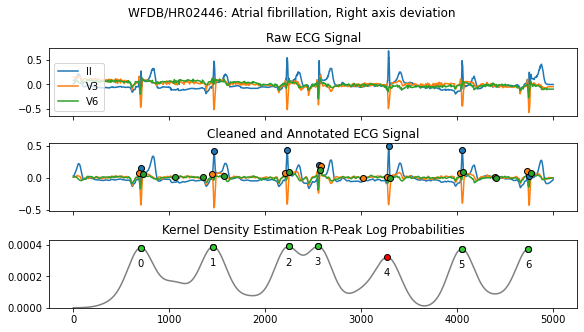

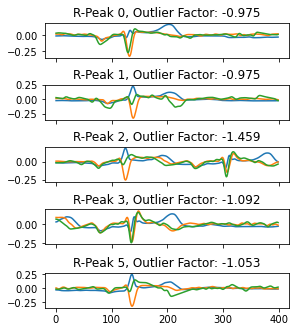

In [21]:
window_size = 400
def _generate_beats(idx):
    ECG_LEAD_NAMES = (
        "I",
        "II",
        "III",
        "aVR",  # 3
        "aVL",
        "aVF",
        "V1",   # 6
        "V2",
        "V3",
        "V4",
        "V5",
        "V6",
    )
    
    # TAKE aVR, V1, and a bad signal
    use_idx = (1, 8, 11)
    sig_labs = [ECG_LEAD_NAMES[ui] for ui in use_idx]

    p_signal = root["cleaned/p_signal"][idx].reshape(
        root["raw/p_signal_shape"][idx], order="C"
    )
    a, b, fs = root["raw/meta"][idx]
    dxs = root["raw/dx"][idx]
    str_abbrvs = [
        snomed_map[str(dx)][1].capitalize() for dx in dxs if dx in SCORED_CODES
    ]
    # print(a, b,str_abbrvs)

    raw_p_signal = root["raw/p_signal"][idx].reshape(
        root["raw/p_signal_shape"][idx], order="C"
    )
    
    def nk_ecg_peaks(cleaned_signal, sampling_rate=fs):
        try:
            _, ecg_r_peaks_dict = nk.ecg_peaks(
                cleaned_signal,
                sampling_rate=sampling_rate,
                method="neurokit",
                correct_artifacts=True,
            )
            r_peaks = ecg_r_peaks_dict["ECG_R_Peaks"].tolist()
            return r_peaks
        except Exception:
            return []

    all_r_peaks = list(map(nk_ecg_peaks, p_signal.T))
    
    # Join all of the R-peaks into a single vector
    all_r_peaks_flat = np.concatenate(all_r_peaks)[:, np.newaxis]
    
    
    ub = np.max(all_r_peaks_flat) + 1
    clf_rpeaks = np.zeros((ub, len(all_r_peaks)))
    print(clf_rpeaks.shape)
    for lead_idx, lead_r_peaks in enumerate(all_r_peaks):        
        clf_rpeaks[[lead_r_peaks], lead_idx] = 1
    print(clf_rpeaks)
    clf = LocalOutlierFactor(n_neighbors=11)
    clf.fit_predict(clf_rpeaks.T)
    print(
        sorted(enumerate(clf.negative_outlier_factor_.tolist()), key=lambda x: x[1])
    )

    sig_range = np.linspace(0, all_r_peaks_flat.max(), len(p_signal))[:, np.newaxis]

    # Find the peaks with bandwidth proportional to rough mean RR
    mean_beats_detected = np.mean([len(r_peaks) for r_peaks in all_r_peaks])
    rough_meanrr = np.mean(
        [np.diff(r_peaks).mean() for r_peaks in all_r_peaks if len(r_peaks) >= 2 and len(r_peaks) >= mean_beats_detected]
    )
    kde = KernelDensity(bandwidth=rough_meanrr / 4).fit(all_r_peaks_flat)
#     kde = KernelDensity(bandwidth=5000).fit(all_r_peaks_flat)

    log_dens = kde.score_samples(sig_range)
    dens = np.exp(log_dens)
    peaks, _ = ss.find_peaks(dens)

    # keep only the peaks that are greater than thereshold density
    threshold_peak_density = dens[peaks].mean() - (2 * dens[peaks].std())
    valid_peaks = peaks[dens[peaks] > threshold_peak_density]
    
    # try to visualize these signals better
    plot_norm_signal = normalize(p_signal, axis=0)
    
    # DISPLAY/DEBUG
    fig, axs = plt.subplots(3, sharex=True, figsize=(8, 4.5), constrained_layout=True)
    record_name = record_files[idx][5:]
    labels = ", ".join(str_abbrvs)
    fig.suptitle(f"{record_name}: {labels}")
    axs[0].set_title("Raw ECG Signal")
    axs[0].plot(np.take(raw_p_signal, use_idx, axis=1), label=sig_labs)
    axs[0].legend(sig_labs, loc="lower left")

    axs[1].set_title("Cleaned and Annotated ECG Signal")
    ref_lines = axs[1].plot(
        # np.take(plot_norm_signal, use_idx, axis=1),
        np.take(p_signal, use_idx, axis=1),
        label=sig_labs
    )

    # annotate signal wise R-peaks?
    for ridx, uidx in enumerate(use_idx):
        axs[1].plot(
            all_r_peaks[uidx],
            #np.take(plot_norm_signal[:, uidx], all_r_peaks[uidx]),
            np.take(p_signal[:, uidx], all_r_peaks[uidx]),
            "o",
            color=ref_lines[ridx].get_color(),
            markeredgecolor="black"
        )
    # axs[1].set_yscale("symlog")

    axs[2].set_title("Kernel Density Estimation R-Peak Log Probabilities")
    axs[2].plot(sig_range[:, 0], dens, color="gray")
    axs[2].plot(sig_range[peaks], dens[peaks], "o", color="red", markeredgecolor="black")
    axs[2].plot(sig_range[valid_peaks], dens[valid_peaks], "o", color="limegreen", markeredgecolor="black")
    for idx, (x, y) in enumerate(zip(sig_range[peaks], dens[peaks])):
        axs[2].text(
            x, y-0.0001, idx,
            horizontalalignment='center',
            verticalalignment='center')
    axs[2].set_ylim([0, max(dens) * 1.1])
    # fig.suptitle(f"Prior Resample {p_signal.shape}")
#     for vpeak in sig_range[valid_peaks]:
#         plt.axvline(x=vpeak)
    plt.savefig("fig/3_sig_raw_clean_peaks.pdf", dpi=300)
    plt.show()
    
#     r_peak_idxs[idx] = all_r_peaks
#     valid_r_peak_idxs[idx] = valid_peaks

    # resample the signal such that the mean distance between
    # valid R-peaks is equal to `window_size`
    scaling_indicies = sig_range[valid_peaks].squeeze()
    scaling_indicies = np.insert(scaling_indicies, 0, 0)
    scaling_indicies = np.append(scaling_indicies, len(p_signal))
    peak_diff_dist = np.diff(scaling_indicies)
    mean_peak_diff_dist = peak_diff_dist.mean()
    resamp_to_len = (len(p_signal) / mean_peak_diff_dist) * window_size
    resamp_to_len = int(np.ceil(resamp_to_len))
    p_signal = ss.resample(p_signal, resamp_to_len)

    # resample the peaks so we don't have to calculate again
    scaling_factor = window_size / mean_peak_diff_dist
    upscaled_peak_diff_dist = peak_diff_dist * scaling_factor
    scaled_indicies = np.r_[scaling_indicies[0], upscaled_peak_diff_dist].cumsum()
    scaled_indicies = scaled_indicies[1:-1]

    valid_window_idxs = [
        idx for (idx, val) in enumerate(dens[peaks] > threshold_peak_density) if val
    ]
    
    # slice up the windows and return the new matrices
    valid_windows = []
    sc_loffset = window_size * 0.33
    for idx, sc in enumerate(scaled_indicies):
        left_offset = int(np.floor(sc - sc_loffset))
        scaled_window = p_signal[left_offset : left_offset + window_size]
        if len(scaled_window) != window_size:
            # ignore windows that don't fit into window size
            continue
        valid_windows.append(scaled_window)

    valid_windows = np.stack(valid_windows)

    norm_windows = np.transpose(
        np.stack(
            list(map(normalize, np.transpose(valid_windows, axes=(0, 2, 1))))
        ),
        axes=(0, 2, 1),
    )
    
    outlier_idx = 0  # only one beat extracted case
    if len(norm_windows) > 1:
        clf = LocalOutlierFactor(
            n_neighbors=max(
                1, min(len(norm_windows) - 1, len(norm_windows) // 2)
            )
        )
        clf.fit_predict(norm_windows.reshape(len(norm_windows), -1))
        outlier_idx = clf.negative_outlier_factor_.argmin()
    
    fig, axs = plt.subplots(len(norm_windows), sharex=True, figsize=(4,4.5), constrained_layout=True)
    for idx, norm_window in enumerate(norm_windows):
        title = f"R-Peak {valid_window_idxs[idx]}, Outlier Factor: {clf.negative_outlier_factor_[idx]:.3f}"
#         if idx == outlier_idx:
#             title += "; Outlier"
        axs[idx].set_title(title)
        axs[idx].plot(np.take(norm_window, use_idx, axis=1))
    plt.savefig("fig/3_sig_r_peak_windows.pdf", dpi=300)
    plt.show()

    return valid_windows

_generate_beats(23117)  # really nice one showing abnormality

None

### Kludge in old CinC 2020 experiment

In [22]:
import json
import joblib
import pandas as pd
import tsfresh
from utils.neurokit2_parallel import lead_to_feature_dataframe, ECG_LEAD_NAMES, parse_fc_parameters

In [23]:
importances_fp = "physionet-challenge-2020/importances_rank.json"
limit_features_to = 1000
with open(importances_fp) as importancesfile:
    importance_data = json.load(importancesfile)
    important_fields = importance_data["sorted_keys"][:limit_features_to]
    fc_parameters = parse_fc_parameters(important_fields)
    fieldnames = ["header_file",] + sorted(important_fields)


In [24]:
def _engineer_features(idx):
    raw_signal = root["raw/p_signal"][idx].reshape(
        root["raw/p_signal_shape"][idx], order="C"
    )
    cleaned_signal = root["cleaned/p_signal"][idx].reshape(
        root["raw/p_signal_shape"][idx], order="C"
    )
    age, sex, fs = root["raw/meta"][idx]

    sig_len, num_leads = raw_signal.shape
#     record_features = joblib.Parallel(n_jobs=num_leads, verbose=0)(
#         joblib.delayed(lead_to_feature_dataframe)(
#             raw_signal[:, i],
#             cleaned_signal[:, i],
#             ECG_LEAD_NAMES[i],
#             fs,
#             fc_parameters
#         )
#         for i in range(num_leads)
#     )
    record_features = [
        lead_to_feature_dataframe(
            raw_signal[:, i],
            cleaned_signal[:, i],
            ECG_LEAD_NAMES[i],
            fs,
            fc_parameters
        )
        for i in range(num_leads)
    ]
    # df = pd.concat([pd.DataFrame({"age": (age,), "sex": (sex,)})] + record_features, axis=1)
    df = pd.concat([pd.DataFrame({"age": (age,)})] + record_features, axis=1)    #return df.to_numpy()[0]
    # return df
    return df.to_numpy()[0]

# print(_engineer_features(0).shape)
# print(_engineer_features(9).shape)
print(_engineer_features(31).shape)

(1000,)


In [25]:
default_fc_parameters = {'agg_linear_trend': [{'attr': 'intercept', 'chunk_len': 10, 'f_agg': 'var'}, {'attr': 'stderr', 'chunk_len': 10, 'f_agg': 'max'}], 'approximate_entropy': [{'m': 2, 'r': 0.3}, {'m': 2, 'r': 0.9}], 'change_quantiles': [{'f_agg': 'mean', 'isabs': False, 'qh': 0.4, 'ql': 0.2}, {'f_agg': 'mean', 'isabs': True, 'qh': 0.8, 'ql': 0.0}], 'cid_ce': [{'normalize': True}], 'energy_ratio_by_chunks': [{'num_segments': 10, 'segment_focus': 3}], 'fft_coefficient': [{'attr': 'abs', 'coeff': 15}, {'attr': 'abs', 'coeff': 16}, {'attr': 'angle', 'coeff': 1}, {'attr': 'imag', 'coeff': 9}, {'attr': 'real', 'coeff': 16}, {'attr': 'real', 'coeff': 2}, {'attr': 'real', 'coeff': 4}, {'attr': 'real', 'coeff': 6}, {'attr': 'real', 'coeff': 8}], 'longest_strike_below_mean': None, 'partial_autocorrelation': [{'lag': 7}], 'quantile': [{'q': 0.7}], 'range_count': [{'max': 1, 'min': -1}], 'ratio_beyond_r_sigma': [{'r': 0.5}], 'skewness': None, 'time_reversal_asymmetry_statistic': [{'lag': 3}]}
column_value = "TEST_hb"
hb_df = tsfresh.extract_features(
    pd.DataFrame(
        {
            "lead": [column_value,],
            "time": [0,],
            column_value: [0.5,],
        }
    ),
    column_id="lead",
    column_sort="time",
    column_value=column_value,
    show_warnings=False,
    disable_progressbar=True,
    default_fc_parameters=default_fc_parameters,
    n_jobs=0,
)
hb_df

variable,"TEST_hb__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""var""","TEST_hb__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""max""",TEST_hb__approximate_entropy__m_2__r_0.3,TEST_hb__approximate_entropy__m_2__r_0.9,"TEST_hb__change_quantiles__f_agg_""mean""__isabs_False__qh_0.4__ql_0.2","TEST_hb__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.0",TEST_hb__cid_ce__normalize_True,TEST_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_3,"TEST_hb__fft_coefficient__attr_""abs""__coeff_15","TEST_hb__fft_coefficient__attr_""abs""__coeff_16",...,"TEST_hb__fft_coefficient__attr_""real""__coeff_4","TEST_hb__fft_coefficient__attr_""real""__coeff_6","TEST_hb__fft_coefficient__attr_""real""__coeff_8",TEST_hb__longest_strike_below_mean,TEST_hb__partial_autocorrelation__lag_7,TEST_hb__quantile__q_0.7,TEST_hb__range_count__max_1__min_-1,TEST_hb__ratio_beyond_r_sigma__r_0.5,TEST_hb__skewness,TEST_hb__time_reversal_asymmetry_statistic__lag_3
id,,,,,,,,,,,,,,,,,,,,,
TEST_hb,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,0.5,1.0,0.0,NaN,0.0


# Meta information

In [26]:
import seaborn as sns

0.11.0


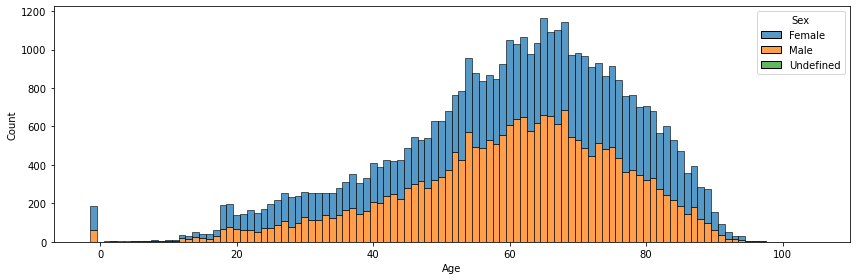

In [52]:
# ages = root["raw/meta"][:, 0]
# genders = root["raw/meta"][:, 1]

# ages = np.where(ages >= 0, ages, np.nan)
# ages = ages[~np.isnan(ages)]

# age_desc = stats.describe(ages, nan_policy="omit")
# print(len(ages) - age_desc.nobs)
# print(age_desc)
# ax = sns.violinplot(ages, orient="v", )
# ax.set_xlabel("Age")
# print(genders)
# print(len(genders[np.isnan(genders)]))

# print(len(genders[np.nonzero(genders)]) / len(genders))
# print(1 - (len(genders[np.nonzero(genders)]) / len(genders)))
print(sns.__version__)

meta_df = pd.DataFrame(root["raw/meta"], columns=["Age", "Sex", "Sampling Rate"])
meta_df["Sex"].replace(0, "Male", inplace=True)
meta_df["Sex"].replace(1, "Female", inplace=True)
meta_df["Sex"].replace(-1, "Undefined", inplace=True)

fig, ax = plt.subplots(1, figsize=(12, 4))

ax = sns.histplot(
    meta_df,
    x="Age",
    hue="Sex",
    multiple="stack",
    stat="count",
    discrete=True,
    ax=ax,
    hue_order=["Female", "Male", "Undefined"]
)
plt.tight_layout()
plt.savefig("fig/age_sex_hist.pdf", dpi=300)
plt.show()
# plt.yscale("linear")

In [53]:
meta_df[meta_df["Sex"] == "Undefined"]

,Age,Sex,Sampling Rate
42905,-1,Undefined,1000
